In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras import activations
import matplotlib.pyplot as plt

In [2]:
data = yf.download(tickers='BTC-USD', start="2023-01-01", end="2023-06-10", interval = '1h')['Close']
#print(data)

[*********************100%***********************]  1 of 1 completed


In [3]:
# data pre-processing

scaler = MinMaxScaler()
close_price = data.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)


SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [6]:
# the LSTM model


DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  LSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(tf.keras.layers.Activation('linear'))

#   TRAINING

BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/5
49/49 [==============================] - 24s 431ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 2/5
49/49 [==============================] - 20s 407ms/step - loss: 0.0098 - val_loss: 0.0053
Epoch 3/5
49/49 [==============================] - 20s 408ms/step - loss: 0.0032 - val_loss: 3.2660e-04
Epoch 4/5
49/49 [==============================] - 20s 403ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 5/5
49/49 [==============================] - 20s 415ms/step - loss: 0.0047 - val_loss: 0.0017


6/6 [==============================] - 1s 72ms/step


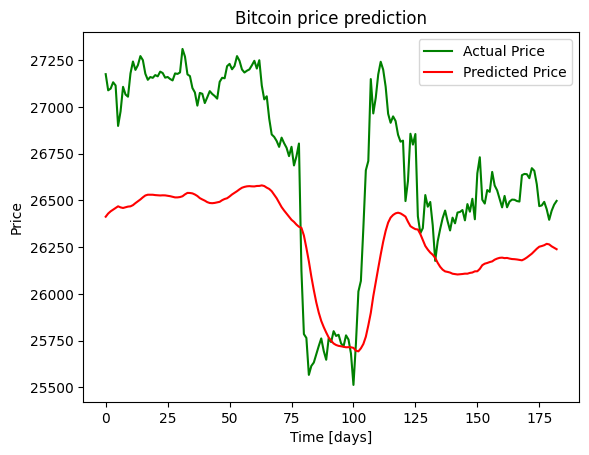

In [7]:
#   BTC PREDICTION

y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [8]:


#df = pd.DataFrame({'actual': y_test_inverse, 'predict': y_hat_inverse})
df1 = pd.DataFrame(y_hat_inverse)
df2 = pd.DataFrame(y_test_inverse)
result = pd.concat([df1, df2], axis=1)
result.columns = ['Predict', 'Actual']
result

,Predict,Actual
0,26412.746094,27174.710938
1,26429.777344,27088.357422
2,26441.554688,27097.388672
3,26450.644531,27131.419922
4,26460.158203,27114.099609
...,...,...
178,26267.738281,26452.828125
179,26264.761719,26396.167969
180,26254.373047,26444.554688
181,26246.527344,26477.042969


In [14]:
initial_capital = 100000
capital = initial_capital
position = None
profit_loss = 0
trades = []
#print(len(result)-1)
for i in range(len(result)-1):
    if position is None:
        if result['Predict'][i + 1] > result['Predict'][i]:
            position = 'long'
            entry_price = result['Actual'][i]
            
        else:
            position = 'short'
            entry_price = result['Actual'][i]

    if position == 'long' :
        exit_price = result['Actual'][i + 1]
        trade_profit_loss = (exit_price - entry_price) / entry_price * capital 
        trades.append((entry_price, exit_price, trade_profit_loss))
        profit_loss += trade_profit_loss
        #print(profit_loss)
        position = None

    if position == 'short':
        exit_price = result['Actual'][i + 1]
        trade_profit_loss = (entry_price - exit_price) / entry_price * capital
        trades.append((entry_price, exit_price, trade_profit_loss))
        profit_loss += trade_profit_loss
        #print(profit_loss)
        position = None

    capital += trade_profit_loss

final_capital = capital
print('Initial Capital: 100000 USD')
print(f"Final Capital: {final_capital} USD")

print("\nTrades:")
for trade in trades:
    entry_price, exit_price, trade_profit_loss = trade
    if entry_price > exit_price:
        trade_type = 'Long'
    else:
        trade_type = 'Short'
    print(f"{trade_type} Position: Entry Price: {entry_price:.2f} USD, Exit Price: {exit_price:.2f} USD, Profit/Loss: {trade_profit_loss:.2f} USD")

num_trades = len(trades)

print(f"\nNumber of Trades: {num_trades}")    


Initial Capital: 100000 USD
Final Capital: 104546.86922163116 USD

Trades:
Long Position: Entry Price: 27174.71 USD, Exit Price: 27088.36 USD, Profit/Loss: -317.77 USD
Short Position: Entry Price: 27088.36 USD, Exit Price: 27097.39 USD, Profit/Loss: 33.23 USD
Short Position: Entry Price: 27097.39 USD, Exit Price: 27131.42 USD, Profit/Loss: 125.23 USD
Long Position: Entry Price: 27131.42 USD, Exit Price: 27114.10 USD, Profit/Loss: -63.74 USD
Long Position: Entry Price: 27114.10 USD, Exit Price: 26898.00 USD, Profit/Loss: -795.24 USD
Short Position: Entry Price: 26898.00 USD, Exit Price: 26975.63 USD, Profit/Loss: -285.68 USD
Short Position: Entry Price: 26975.63 USD, Exit Price: 27107.00 USD, Profit/Loss: -480.66 USD
Long Position: Entry Price: 27107.00 USD, Exit Price: 27065.88 USD, Profit/Loss: -148.99 USD
Long Position: Entry Price: 27065.88 USD, Exit Price: 27054.26 USD, Profit/Loss: -42.12 USD
Short Position: Entry Price: 27054.26 USD, Exit Price: 27178.40 USD, Profit/Loss: 449.79 